# SWOT High Resolution Elevation over Ice Shelves and Comparison to ICESat-2 
<br>

**Authors**
- Zachary Katz, Colorado School of Mines
- Tasha Snow, University of Maryland, NASA Goddard Space Flight Center


```{admonition} Learning Objectives
- Plot availability of SWOT Low Resolution (LR) and High Resolution (HR) over Antarctica
- Obtain spatially coincident ICESat-2 ATL06 and SWOT HR data
    - Correct for differing geophysical corrections between missions
    - Correct for ice advection between acquisitions
- Plot a comparison of ICESat-2 and SWOT elevations over Bach Ice Shelf
```

This tutorial is provided under the MIT license.

# Introduction

In this tutorial, we'll compare data from NASA/CNES's Surface Water and Ocean Topography (SWOT) satellite to NASA's Ice, Cloud, and Land Elevation Satellite 2 (ICESat-2) to assess the performance of SWOT over the Bach Ice Shelf on the Antarctic Peninsula. We will use SWOT's High Resolution (HR) Level 2 Water Mask Raster Image Data Product, Version D (SWOT_L2_HR_Raster_D) due to improved processing of the HR products over ice shelves and compare to ICESat-2's Land Ice Height, Version 6 (ATL06). More information about the SWOT data products, processing, and mission is available [here](https://podaac.jpl.nasa.gov/SWOT?tab=mission-objectives&sections=about%2Bdata). 

To provide examples of Earthaccess search methods, we use a specific granule of SWOT data found using [Earthdata search](https://www.earthdata.nasa.gov/) and search for all ICESAT-2 tracks in a specified bounding box before manually picking one that intersects the SWOT swath at our region of interest.

# Environment Setup and Helper Functions

In this tutorial, we'll compare data from NASA/CNES's Surface Water and Ocean Topography (SWOT) satellite to NASA's Ice, Cloud, and Land Elevation Satellite 2 (ICESat-2) to assess the performance of SWOT over the Bach Ice Shelf on the Antarctic Peninsula. We will use SWOT's High Resolution (HR) Level 2 Water Mask Raster Image Data Product, Version D (SWOT_L2_HR_Raster_D) due to improved processing of the HR products over ice shelves and compare to ICESat-2's Land Ice Height, Version 6 (ATL06). More information about the SWOT data products, processing, and mission is available [here](https://podaac.jpl.nasa.gov/SWOT?tab=mission-objectives&sections=about%2Bdata).

In [1]:
# Install a few packages that are not in the default CryoCloud environment:
%pip install -q pyTMD # For downloading and running the Circum-Antarctic Tidal Simulation (CATS) for tide corrections
%pip install -q icesat2_toolkit # For converting ICESat-2 time to GMT
%pip install -q cmap # For the ice velocity colormap
%pip install -q PyAstronomy # For date conversions
%pip install -q --upgrade --force-reinstall h5coro>=0.0.8 # Fast opening of stream objects using xarray's h5coro backend

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-ai 2.31.2 requires faiss-cpu!=1.8.0.post0,<2.0.0,>=1.8.0, which is not installed.
xmip 0.7.2 requires cf_xarray>=0.6.0, which is not installed.
xmip 0.7.2 requires xarrayutils, which is not installed.
xmip 0.7.2 requires xgcm<0.7.0, which is not installed.
awscli 2.22.15 requires python-dateutil<=2.9.0,>=2.1, but you have python-dateutil 2.9.0.post0 which is incompatible.
awscli 2.22.15 requires urllib3<1.27,>=1.25.4, but you have urllib3 2.5.0 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.7.0 which is i

In [1]:
# Test we have version 0.0.8 of h5coro, if 0.0.6 printed, restart kernel after pip install. 
import h5coro
h5coro.__version__

'0.0.8'

In [3]:
# Imports
import os
import gzip
import shutil
import logging
import warnings
import datetime
import tempfile
from pathlib import Path
from itertools import chain
from PyAstronomy import pyasl
from concurrent.futures import ProcessPoolExecutor
from scipy.interpolate import RegularGridInterpolator

# Data access
import h5py
import s3fs
import fiona
import h5coro
import rasterio
import requests
import earthaccess
import numpy as np
import pandas as pd
import xarray as xr
import icesat2_toolkit
from io import BytesIO
import geopandas as gpd
import cartopy.crs as ccrs

import pyTMD
import timescale  

# Plotting
import shapely
import shapefile
from shapely.plotting import plot_line
from shapely.geometry import LineString

from cmap import Colormap
import cartopy.crs as ccrs
from pyproj import CRS, Transformer

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

# Data path
datapath = Path('/home/jovyan/shared-public/SWOT/data') # Shared data files that cannot be streamed
gl_path = datapath / "Antarctica_masks/scripps_antarctica_polygons_v1.shp" # Grounding line shapefile
kml_hr_path = datapath / "hr_Mar2025_below60S.kml" # Culled kml of HR SWOT orbit to reduce file size
kmz_lr_path = datapath / "lr_Sept2015.kmz" # kmz of LR SWOT orbit
tide_dir = datapath # Tide model directory [subdirectory in this folder must be called CATS2008_v2003]
tide_mod = "CATS2008-v2023" # Tide model name

# PS71 [EPSG:3031] bounding boxe
bbox = [-1970000, 490000, -1820000, 670000] # Bach ice shelf

# Suppress specific RuntimeWarning from pyogrio/GDAL
warnings.filterwarnings("ignore", message=".*ERROR parsing kml Style: No id.*", category=RuntimeWarning)
logging.getLogger("urllib3.connectionpool").setLevel(logging.ERROR)

##############################
# Helper Functions and classes
def xy2ll(x: list[float], y: list[float]) -> tuple[list[float], list[float]]:
    """
    Transform coordinates from Antarctic Polar Stereographic coordinates (x, y)
    to output geodetic coordinates (lon, lat).
    Can also take single floats.

    Parameters
    ----------
    x: list[float]
       Antarctic Polar Stereographic (EPSG:3031) x
    y: list[float]
       Antarctic Polar Stereographic (EPSG:3031) y

    Returns
    -------
    lon: list[float]
         Geodetic longitude in EPSG:4326
    lat: list[float]
         Geodetic latitude in EPSG:4326
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    xy_to_ll = Transformer.from_crs(crs_xy, crs_ll, always_xy=True)
    lon, lat = xy_to_ll.transform(x, y)
    return lon, lat

def ll2xy(lon: list[float], lat: list[float]) -> tuple[list[float], list[float]]:
    """
    Transform coordinates from input geodetic coordinates (lon, lat)
    to output Antarctic Polar Stereographic coordinates (x, y).
    Can also take single floats.

    Parameters
    ----------
    lon: list[float]
         Geodetic longitude in EPSG:4326
    lat: list[float]
         Geodetic latitude in EPSG:4326

    Returns
    -------
    x: list[float]
       Antarctic Polar Stereographic (EPSG:3031) x
    y: list[float]
       Antarctic Polar Stereographic (EPSG:3031) y
    """

    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy=True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

def ps712utm(
    x: list[float], y: list[float], crs: int
) -> tuple[list[float], list[float]]:
    """
    Transform coordinates from input Antarctic Polar Stereographic coordinates
    (x, y)UTM coordinates (utmx, utmy) to output UTM coordinates (utmx, utmy)
    Can also take lists of floats!

    Parameters
    x - Antarctic Polar Stereographic (EPSG:3031) x [float]
    y - Antarctic Polar Stereographic (EPSG:3031) y [float]
    crs - EPSG code of UTM projection [int]

    Returns
    utmx - UTM x coordinate [float]
    utmy - UTM y coordinate [float]
    """

    crs_utm = CRS(f"EPSG:{crs}")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_xy, crs_utm, always_xy=True)
    utmx, utmy = ll_to_xy.transform(x, y)
    return utmx, utmy

# Tide class
class Tide:
    """
    An instance of class Tides determines the tidal model to use and its location.
    """

    def __init__(self, model: str, model_loc: str) -> None:
        """Initialize a tidal model

        Parameters
        ----------
        model : str
            Model to pull tides from
        model_loc : str
            Location of model file
        """
        self.model = model
        self.model_loc = model_loc

    def tidal_elevation(
        self, lons: list, lats: list, datetimes: list, consts=None
    ) -> xr.DataArray:
        """
        Calculate the tidal elevation at the given locations and times. Adapted
        from pyTMD example: https://github.com/tsutterley/pyTMD/blob/main/notebooks/Plot%20Tide%20Forecasts.ipynb
        If more locations than times, uses pyTMD map; if more times than
        locations, uses pyTMD time_series.

        Parameters
        ----------
        lons : list
            Longitudes for tide calculation
        lats : list
            Latitudes for tide calculation
        datetimes : list
            Times for tide calculation
        consts : list
            List of constituents to use, defaults to all
        Returns
        -------
        tides : xarray.DataArray
            Tides [cm] at each location (lon, lat) and time (t).
        """
        # Convert dates to date since 01 Jan 1992 [The format pyTMD wants it in]
        years = np.array([date.year for date in datetimes])
        months = np.array([date.month for date in datetimes])
        days = np.array([date.day for date in datetimes])
        hours = np.array([date.hour for date in datetimes])
        minutes = np.array([date.minute for date in datetimes])
        tide_time = timescale.time.convert_calendar_dates(
            year=years, month=months, day=days, hour=hours, minute=minutes
        )

        # Setup model
        model = pyTMD.io.model(self.model_loc, format="netcdf").elevation(self.model)
        constituents = pyTMD.io.OTIS.read_constants(
            model.grid_file,
            model.model_file,
            model.projection,
            type=model.type,
            grid=model.format,
            apply_flexure=False,
        )
        c = constituents.fields

        DELTAT = np.zeros_like(tide_time)
        amp, ph, D = pyTMD.io.OTIS.interpolate_constants(
            np.atleast_1d(lons),
            np.atleast_1d(lats),
            constituents,
            # model.projection,
            type=model.type,
            method="spline",
            extrapolate=True,
        )

        # Complex phase and constituent oscillation
        cph = -1j * ph * np.pi / 180.0
        hc = amp * np.exp(cph)

        # Cull c to particular constituents if requested
        if consts is not None:
            c = np.array(c)
            c = c[np.isin(c, consts)]
        if len(lons) > 1:
            tide_holder = []
            for i in range(len(datetimes)):
                tide = self.tidal_elevation_map(
                    tide_time[i], hc, c, DELTAT[i], model, consts
                )
                tide_holder.append(tide)
        else:
            tide_holder = self.tidal_elevation_time_series(
                tide_time, hc, c, DELTAT, model, consts
            )
            tide_holder = np.atleast_2d(tide_holder).T.tolist()

        # Put in xarray
        obj_arr = [LatLon(lat, lon) for lat, lon in zip(lats, lons)]
        tides = xr.DataArray(
            dims=("t", "lat_lon"),
            coords={"t": datetimes, "lat_lon": obj_arr},
            data=tide_holder,
            attrs=dict(
                description="Tide Height",
                units="cm",
            ),
        )

        return tides

    @staticmethod
    def tidal_elevation_map(
        tide_time: float, hc: list, c: list, delat: float, model: pyTMD.io.model, consts
    ) -> np.ndarray:
        """Use pyTMD's map function if more lat long pairs than times:

        Parameters
        ----------
        tide_time : float
            Tide time in pyTMD format
        hc : list
            Harmonic constants
        c : list
            Constituent ids
        delat : float
            Time correction
        model : pyTMD.io.model
            pyTMD model to use

        Returns
        -------
        np.ndarray
            Tide elevations at each location and time in m
        """

        # Predict tides and minor corrections
        TIDE = pyTMD.predict.map(
            tide_time, hc, c, deltat=delat, corrections=model.format
        )
        if consts is None:
            MINOR = pyTMD.predict.infer_minor(
                tide_time, hc, c, deltat=delat, corrections=model.format
            )
            TIDE.data[:] += MINOR.data[:]
        TIDE.data[:] *= 100.0  # Convert to cm
        return TIDE

    @staticmethod
    def tidal_elevation_time_series(
        tide_time: list, hc: list, c: list, delat: float, model: pyTMD.io.model, consts
    ):
        """Use pyTMD's time_series function if more lat long pairs than times:

        Parameters
        ----------
        tide_time : list
            Tide times in pyTMD format
        hc : list
            Harmonic constants
        c : list
            Constituent ids
        delat : float
            Time correction
        model : pyTMD.io.model
            pyTMD model to use
        Returns
        -------
        np.ndarray
            Tide elevations at each location and time in m
        """
        # Predict tides and minor corrections
        TIDE = pyTMD.predict.time_series(
            tide_time, hc, c, deltat=delat, corrections=model.format
        )
        if consts is None:
            MINOR = pyTMD.predict.infer_minor(
                tide_time, hc, c, deltat=delat, corrections=model.format
            )
            TIDE.data[:] += MINOR.data[:]
        TIDE.data[:] *= 100.0  # Convert to cm
        return TIDE


class LatLon:
    """
    An instance of class LatLon stores at latitude, longitude pair.
    """

    def __init__(self, lat: float, lon: float) -> None:
        """Initialize a latitude, longitude pair

        Parameters
        ----------
        lat : float
            Latitude
        lon : float
            Longitude
        """
        self.lat = lat
        self.lon = lon

def plot_shapefile(
    records: list[shapefile._Record],
    shapes: list[shapefile.Shape],
    ax,
    colors: list[str],
    transform,
    fill: bool = False,
) -> None:
    """
    Plots the given records and shapes on axis ax.

    Parameters
    ----------
    records : list[shapefile._Record]
        Shapely record containing shape classification
    shapes : list[shapefile.Shape]
        Shapely shape points
    ax : cartopy.mpl.geoaxes.GeoAxes
        Axes to polot on
    colors : list[str]
       [Grounded ice color, Ice Shelf color]; Must be length 2
    """
    for record, shape in zip(records, shapes):
        classification = record[field_names.index("Id_text")]
        points = shape.points
        parts = list(shape.parts)
        parts.append(
            len(points)
        )  # Append the end index of the last part of the shapefile
        for i in range(len(parts) - 1):
            part = points[parts[i] : parts[i + 1]]
            if (
                classification == "Isolated island"
                or classification == "Ice rise or connected island"
                or classification == "Grounded ice or land"
            ):
                if fill:
                    ax.fill(*zip(*part), color=colors[0], zorder=2, transform=transform)
                else:
                    ax.plot(
                        *zip(*part),
                        color=colors[0],
                        linewidth=1.5,
                        zorder=2,
                        transform=transform,
                    )
            elif classification == "Ice shelf":
                if fill:
                    ax.fill(*zip(*part), color=colors[1], zorder=2, transform=transform)
                else:
                    ax.plot(
                        *zip(*part),
                        color=colors[1],
                        linewidth=1.5,
                        zorder=2,
                        transform=transform,
                    )
            else:
                print(f"Unknown classification: {classification}")

# Compare and Plot SWOT LR and HR Coverage over Antarctica

In [4]:
# Download Scripps Antarctic Grounding Line if it doesn't exist
# Scripps Antarctic Grounding Line
# [dataset page](https://doi.pangaea.de/10.1594/PANGAEA.819147)
# [direct download](https://doi.pangaea.de/10013/epic.42133.d001)
# scripps_antarctica_polygons_v1.shp

datapath.mkdir(parents=True, exist_ok=True)

if not gl_path.exists():
    # Download URL
    url = "https://doi.pangaea.de/10013/epic.42133.d001"
    
    # Download the ZIP file
    response = requests.get(url)
    response.raise_for_status()  # raises error if download fails
    
    # Extract ZIP contents to gl_path
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        z.extractall(datapath)
    
    print(f"Shapefiles extracted to: {datapath}")

In [5]:
# Open and trim HR coverage to south of 60S if not already done
# SWOT Mask High Resolution
# [dataset page] https://podaac.jpl.nasa.gov/SWOT-events/SWOT_events.html
# [direct download] https://podaac.jpl.nasa.gov/SWOT-events/swot_science_hr_Mar2025-v10_perPass.kml
# swot_science_hr_Mar2025-v10_perPass.kml

# Wall time: 23min 13s

if not os.path.exists(kml_hr_path):
    print("LOOP")

    # Download the KML
    url = "https://podaac.jpl.nasa.gov/SWOT-events/swot_science_hr_Nov2024-v09-seasonal_perPass.kml"
    response = requests.get(url)
    response.raise_for_status()
    
    # Save to a temporary file
    with tempfile.NamedTemporaryFile(suffix=".kml", delete=False) as tmp:
        tmp.write(response.content)
        kml_path = tmp.name
    
    # Try to read all layers, with error handling
    layers = fiona.listlayers(kml_path)
    gdfs = {}
    
    for layer in layers:
        try:
            gdf_layer = gpd.read_file(kml_path, driver="KML", layer=layer)
            if not gdf_layer.empty:
                gdfs[layer] = gdf_layer
        except Exception as e:
            print(f"Failed to load layer '{layer}': {e}")
    
    # Remove tmp file
    os.remove(kml_path)
    
    # Combine loaded layers
    if gdfs:
        gdf = gpd.GeoDataFrame(pd.concat(gdfs.values(), ignore_index=True))
        gdf = gdf[gdf.geometry.bounds["miny"] < -60]
        print(f"Loaded {len(gdf)} features")
    else:
        raise RuntimeError("No valid layers could be loaded.")
    
    gdf.to_file(kmz_hr_path, driver="KML")
    print(f"SWOT HR orbit extracted to: {kmz_lr_path}")

In [6]:
# Download LR coverage if it doesn't exist
# SWOT Mask Low Resolution
# [dataset page] https://www.aviso.altimetry.fr/en/missions/current-missions/swot/orbit.html
# [direct download] https://www.aviso.altimetry.fr/fileadmin/documents/missions/Swot/swot_science_orbit_sept2015-v2_10s.kmz
# swot_science_orbit_sept2015-v2_10s.kml

if not os.path.exists(kmz_lr_path):
    # Download URL
    url = "https://www.aviso.altimetry.fr/fileadmin/documents/missions/Swot/swot_science_orbit_sept2015-v2_10s.kmz"
    
    # Download the file
    response = requests.get(url)
    response.raise_for_status()  # raises error if download fails

    with open(kmz_lr_path, "wb") as f:
            f.write(response.content)

    print(f"SWOT LR orbit extracted to: {kmz_lr_path}")

In [7]:
# Open trimmed 60S HR orbit file
layers = fiona.listlayers(kml_hr_path)
gdfs = {
    layer: gpd.read_file(kml_hr_path, driver="KML", layer=layer) for layer in layers[:]
}
gdf = gpd.GeoDataFrame(pd.concat(gdfs.values(), ignore_index=True))
print(f"Loaded {len(gdf)} features from {len(gdfs)} layers.")

ps71_projection = ccrs.Stereographic(
    central_latitude=-90, central_longitude=0, true_scale_latitude=-71
)
gdf_proj = gdf.to_crs(ps71_projection.proj4_init)
gdf_proj_hr = gdf_proj[~gdf_proj["Name"].str.contains("Nadir")]

Loaded 194 features from 1 layers.


In [9]:
# Open LR orbit file
# Wall time: ~5 min
layers = fiona.listlayers(kmz_lr_path)
gdfs = {}

for layer in layers:
    try:
        gdf = gpd.read_file(kmz_lr_path, driver="KML", layer=layer)
        if not gdf.empty:
            gdfs[layer] = gdf
    except Exception as e:
        print(f"Skipped layer '{layer}' due to error: {e}")

# Combine all non-empty layers
if not gdfs:
    raise RuntimeError("No valid layers were loaded.")
gdf = gpd.GeoDataFrame(pd.concat(gdfs.values(), ignore_index=True))
print(f"Loaded {len(gdf)} features from {len(gdfs)} layers.")

gdf_proj = gdf.to_crs(ps71_projection.proj4_init)
gdf_proj_lr = gdf_proj[~gdf_proj["Name"].str.contains("Nadir")]

Loaded 1168 features from 584 layers.


(-3000000.0, 3000000.0)

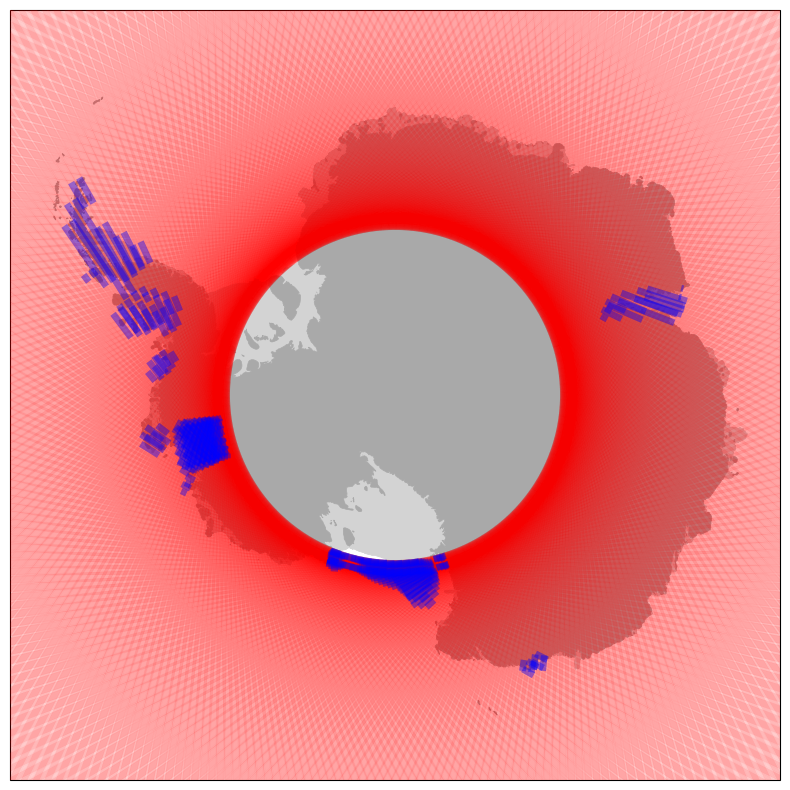

In [10]:
# Plot data availability
fig, ax = plt.subplots(subplot_kw={"projection": ps71_projection}, figsize=(10, 10))

# Antarctica basemap
ice_shelf_polygons = []
grounded_polygons = []

sf = shapefile.Reader(gl_path)
fields = sf.fields[1:]  # Skip deletion flag
field_names = [field[0] for field in fields]

records = sf.records()
shapes = sf.shapes()

for record, shape in zip(records, shapes):
    classification = record[field_names.index("Id_text")]
    points = shape.points
    parts = list(shape.parts)
    parts.append(len(points))  # Append the end index of the prior part
    for i in range(len(parts) - 1):
        part = points[parts[i] : parts[i + 1]]
        if (
            classification == "Isolated island"
            or classification == "Ice rise or connected island"
            or classification == "Grounded ice or land"
        ):
            ax.fill(*zip(*part), color="darkgray", linewidth=0.5, zorder=2)
        elif classification == "Ice shelf":
            ax.fill(*zip(*part), color="lightgray", linewidth=0.5, zorder=2)
        else:
            print(f"Unknown classification: {classification}")

# Plot LR and HR SWOT tracks
gdf_proj_lr.plot(
    ax=ax,
    transform=ps71_projection,
    edgecolor="red",
    facecolor="red",
    alpha=0.1,
    linewidth=0.1,
    zorder=3,
)
gdf_proj_hr.plot(
    ax=ax,
    transform=ps71_projection,
    edgecolor="blue",
    facecolor="blue",
    alpha=0.4,
    linewidth=0.1,
    zorder=3,
)

ax.set_xlim(-3000000, 3000000)
ax.set_ylim(-3000000, 3000000)

# Compare SWOT and ICESat-2 Elevations on Bach Ice Shelf

In [11]:
# Authenticate for accessing NASA data
try:
    auth = earthaccess.login(strategy="netrc") # If user has credentials stored in .netrc file. Never push .netrc to GitHub
except:
    auth = earthaccess.login(strategy="interactive")
creds = auth.get_s3_credentials(daac='NSIDC')

In [12]:
# Open velocity map into memory
# MEaSUREs Phase-Based Antarctica Ice Velocity Map, v2
#[dataset page] https://nsidc.org/data/nsidc-0484/versions/2
#[direct download] https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/MEASURES/NSIDC-0484/2/1996/01/01/antarctica_ice_velocity_450m_v2.nc
#antarctica_ice_velocity_450m_v2.nc

results = earthaccess.search_data(
    short_name="NSIDC-0484",
    cloud_hosted=True,
    temporal=("1996-01-01", "1996-01-02"),
    count=1
)

opened = earthaccess.open(results)
vel = xr.open_dataset(opened[0])

# Crop velocity map and take magnitude
off = 10000
cropped_vel = vel.sel(
    x=slice(bbox[0] - off, bbox[2] + off), y=slice(bbox[3] + off, bbox[1] - off)
)
vel_mag_sliced = np.sqrt(cropped_vel.VX**2 + cropped_vel.VY**2)

oslo = Colormap("crameri:oslo").to_matplotlib() # Velocity colormap

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
# Open Mosaic of Antarctica into memory
#MODIS Mosaic of Antarctica 2009, 750 m, hp1, v1.1 (Must unzip after download):
#Version 2 dataset page currently downloads v1.1?
#[dataset page] https://nsidc.org/data/nsidc-0593/versions/2
#[direct download] https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0593_moa2009_v02/geotiff/moa750_2009_hp1_v02.0.tif.gz
#moa750_2009_hp1_v1.1.tif

# URL of the protected gzip file
url = "https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0593_moa2009_v02/geotiff/moa750_2009_hp1_v02.0.tif.gz"

# Use Earthdata login stored in ~/.netrc (standard for requests)
session = requests.Session()
session.auth = requests.utils.get_netrc_auth(url)

# Add user-agent to mimic a real browser
headers = {"User-Agent": "NASA Earthdata Python client"}

# Download and check for success
response = session.get(url, headers=headers)
response.raise_for_status()

# Confirm content-type is not HTML (debug print)
if b"<html" in response.content[:100].lower():
    raise RuntimeError("Download returned HTML (login failed or wrong credentials?)")

# Decompress the GZip in memory
with gzip.GzipFile(fileobj=BytesIO(response.content)) as gz:
    tif_bytes = BytesIO(gz.read())

# Read with Rasterio from memory
with rasterio.MemoryFile(tif_bytes) as memfile:
    with memfile.open() as moa:
        bounds = moa.bounds
        left, bottom, right, top = bounds.left, bounds.bottom, bounds.right, bounds.top
        moa_dat = moa.read(1)

ext = (left, right, bottom, top)

In [14]:
# Open CATS2008_v2023 into into memory
fs = s3fs.S3FileSystem(anon=True)
fs.ls('pytmd/CATS2008_v2023')

filepath = pyTMD.utilities.get_data_path('data')
model = pyTMD.io.model(filepath, verify=False).elevation('CATS2008-v2023')
model.grid_file.parent.mkdir(parents=True, exist_ok=True)
with fs.open('pytmd/CATS2008_v2023/CATS2008_v2023.nc', 'rb') as fin, open(model.grid_file,'wb') as fout:
    shutil.copyfileobj(fin, fout)

model.grid_file.exists()

True

In [36]:
# Stream one SWOT granule
results = earthaccess.search_data(
    short_name="SWOT_L2_HR_Raster_D",
    temporal=("2025-05-01", "2025-06-30"),
    granule_name="SWOT_L2_HR_Raster_100m_UTM18D_N_x_x_x_033_143_012F_20250523T232533_20250523T232551_PID0_01.nc",
)
file_like = earthaccess.open(results)
ds = xr.open_dataset(file_like[0], engine='h5netcdf')
ds_swot = ds


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
# Stream ICESat-2 Data

# Get spatial and temporal extent to search for IceSat2 data
polygon = [
    [bbox[0], bbox[1]],  # SW
    [bbox[2], bbox[1]],  # SE
    [bbox[2], bbox[3]],  # NE
    [bbox[0], bbox[3]],  # NW
    [bbox[0], bbox[1]],  # SW
]
ll_bbox = []
for coord in polygon:
    tmp = xy2ll(coord[0], coord[1])
    ll_bbox.append(tmp)

st_swot = datetime.datetime.strptime(ds.time_granule_start, "%Y-%m-%dT%H:%M:%S.%fZ")
et_swot = datetime.datetime.strptime(ds.time_granule_end, "%Y-%m-%dT%H:%M:%S.%fZ")
# Search +- 91/2 days (1/2 ICESat2 repeat orbit
st_is2 = st_swot - datetime.timedelta(days=46)
et_is2 = et_swot + datetime.timedelta(days=46)

print(st_swot, st_is2, et_is2)

# Stream ICESat2
results = earthaccess.search_data(
    short_name="ATL06", temporal=(st_is2, et_is2), polygon=ll_bbox
)
print(len(results))

2025-05-23 23:25:33.311658 2025-04-07 23:25:33.311658 2025-07-08 23:25:51.376235
47


In [36]:
"""
# Run this OR the next cell to make arr06, an array of dictionaries with ICESAt-2 data

# Parallelized h5coro implementation
# I/O bound, cpu processing only takes ~1 sec per file but wall time ~20 sec per file
# h5netcdf implementation below currently faster

group = ["/gt1l/land_ice_segments", "/gt1r/land_ice_segments", "/gt2l/land_ice_segments", "/gt2r/land_ice_segments", "/gt3l/land_ice_segments", "/gt3r/land_ice_segments"]

def process_granule(result):
    s3_url = result.data_links(access="direct")
    granule_s3_url = s3_url[0].replace("s3://", "") # remove s3: from start of url
    data_arr = []
    for g in group:
        data = {}
        data["name"] = s3_url
        data['beam'] = beam
        with xr.open_dataset(granule_s3_url, engine='h5coro', group=f'{g}', credentials=creds) as ds:
            data["x"], data["y"] = ll2xy(ds.longitude, ds.latitude) # PS71, meters
            data["h_li"] = ds.h_li # Land Ice Height, meters
            data["t_dt"] = ds.delta_time # GPS seconds since reference epoch
            data['q_flag'] = ds.atl06_quality_summary  # 0 likely no problem; 1 problems #See table 4-3 in IceSat2 ATBD
            
        with xr.open_dataset(granule_s3_url, engine='h5coro', group=f'{g}/dem', credentials=creds) as ds:
            data["geoid_h"] = ds.geoid_h # Geoid height, meters
            data["geoid_free2mean"] = ds.geoid_free2mean
        with xr.open_dataset(granule_s3_url, engine='h5coro', group=f'{g}/geophysical', credentials=creds) as ds:
            data['tide_ocean'] = ds.tide_ocean # Ocean tide, meters
            data["dac"] = ds.dac # Dynamic atmospheric correction, meters
            data['tide_earth'] = ds.tide_earth # Earth tide, meters
            data['tide_earth_free2mean'] = ds.tide_earth_free2mean
            data["tide_pole"] = ds.tide_pole # Pole tide, meters
            data["tide_load"] = ds.tide_load # Load tide, meters
    
        # Mask out bad data
        mask_q = data["q_flag"] == 1
        mask_h_li = data["h_li"] > 3.0e38
        data["h_li"][mask_q] = np.nan
        data["h_li"][mask_h_li] = np.nan
        data_arr.append(data)
    return data_arr
    
with ProcessPoolExecutor(max_workers=4) as exe:
    arr06_seg = exe.map(process_granule, results[:1])

arr06 = list(chain.from_iterable(arr06_seg)) #Flatten

for i, data in enumerate(arr06[:]):
    time = icesat2_toolkit.convert_delta_time(data["t_dt"])
    data["time"] = time["decimal"]
"""

CPU times: user 771 ms, sys: 99.5 ms, total: 871 ms
Wall time: 23.8 s


In [17]:
%%time
# Run this OR the prior cell to make arr06, an array of dictionaries with ICESAt-2 data

# h5netcdf implementation
# Wall time ~8 sec/file

# Wall time 6 min total

arr06 = []

# Earthaccess credentials
s3_creds = auth.get_s3_credentials(daac="NSIDC")
fs = s3fs.S3FileSystem(
    key=s3_creds["accessKeyId"],
    secret=s3_creds["secretAccessKey"],
    token=s3_creds["sessionToken"],
)

print(f"{len(results)} results with up to {len(results)*6} beams")

beam_roots = ["gt1l", "gt1r", "gt2l", "gt2r", "gt3l", "gt3r"]

for result in results[:]:
    s3_url = result.data_links(access='direct')[0].replace("s3://", "")
    
    for beam in beam_roots:
        try:
            with fs.open(s3_url, cache_type="blockcache", block_size=4*1024*1024, mode='rb') as s3file:
                
                # --- Load land_ice_segments base data
                ds_main = xr.open_dataset(
                    s3file,
                    engine='h5netcdf', #h5netcdf
                    group=f"{beam}/land_ice_segments",
                    decode_times=False,
                    driver_kwds={"rdcc_nbytes": 1024*1024}
                )

                data = {
                    "lat": ds_main["latitude"].values,
                    "lon": ds_main["longitude"].values,
                    "h_li": ds_main["h_li"].values,
                    "t_dt": ds_main["delta_time"].values,
                    "q_flag": ds_main["atl06_quality_summary"].values,
                }

                # --- Load DEM subgroup
                ds_dem = xr.open_dataset(
                    s3file,
                    engine='h5netcdf',
                    group=f"{beam}/land_ice_segments/dem",
                    decode_times=False,
                    driver_kwds={"rdcc_nbytes": 1024*1024}
                )
                data["geoid_h"] = ds_dem["geoid_h"].values
                data["geoid_free2mean"] = ds_dem["geoid_free2mean"].values

                # --- Load Geophysical subgroup
                ds_geo = xr.open_dataset(
                    s3file,
                    engine='h5netcdf',
                    group=f"{beam}/land_ice_segments/geophysical",
                    decode_times=False,
                    driver_kwds={"rdcc_nbytes": 1024*1024}
                )
                data["tide_ocean"] = ds_geo["tide_ocean"].values
                data["dac"] = ds_geo["dac"].values
                data["tide_earth"] = ds_geo["tide_earth"].values
                data["tide_earth_free2mean"] = ds_geo["tide_earth_free2mean"].values
                data["tide_pole"] = ds_geo["tide_pole"].values
                data["tide_load"] = ds_geo["tide_load"].values

                # Coordinate transform
                data["x"], data["y"] = ll2xy(data["lon"], data["lat"])
                data["name"] = s3_url
                data['beam'] = beam

                # Apply masks
                mask_q = data["q_flag"] == 1
                mask_h_li = data["h_li"] > 3.0e38
                data["h_li"][mask_q] = np.nan
                data["h_li"][mask_h_li] = np.nan

                arr06.append(data)

        except Exception as e:
            print(f"Skipping beam {beam} in file {s3_url}")
            print(e)
            continue

for i, data in enumerate(arr06[:]):
    time = icesat2_toolkit.convert_delta_time(data["t_dt"])
    data["time"] = time["decimal"]

47 results with up to 282 beams
CPU times: user 4min 15s, sys: 7.17 s, total: 4min 22s
Wall time: 5min 9s


nsidc-cumulus-prod-protected/ATLAS/ATL06/007/2025/05/15/ATL06_20250515130244_09102710_007_01.h5
gt1l
nsidc-cumulus-prod-protected/ATLAS/ATL06/007/2025/05/15/ATL06_20250515130244_09102710_007_01.h5
gt1r
nsidc-cumulus-prod-protected/ATLAS/ATL06/007/2025/05/15/ATL06_20250515130244_09102710_007_01.h5
gt2l
nsidc-cumulus-prod-protected/ATLAS/ATL06/007/2025/05/15/ATL06_20250515130244_09102710_007_01.h5
gt2r
nsidc-cumulus-prod-protected/ATLAS/ATL06/007/2025/05/15/ATL06_20250515130244_09102710_007_01.h5
gt3l
nsidc-cumulus-prod-protected/ATLAS/ATL06/007/2025/05/15/ATL06_20250515130244_09102710_007_01.h5
gt3r


(490000.0, 670000.0)

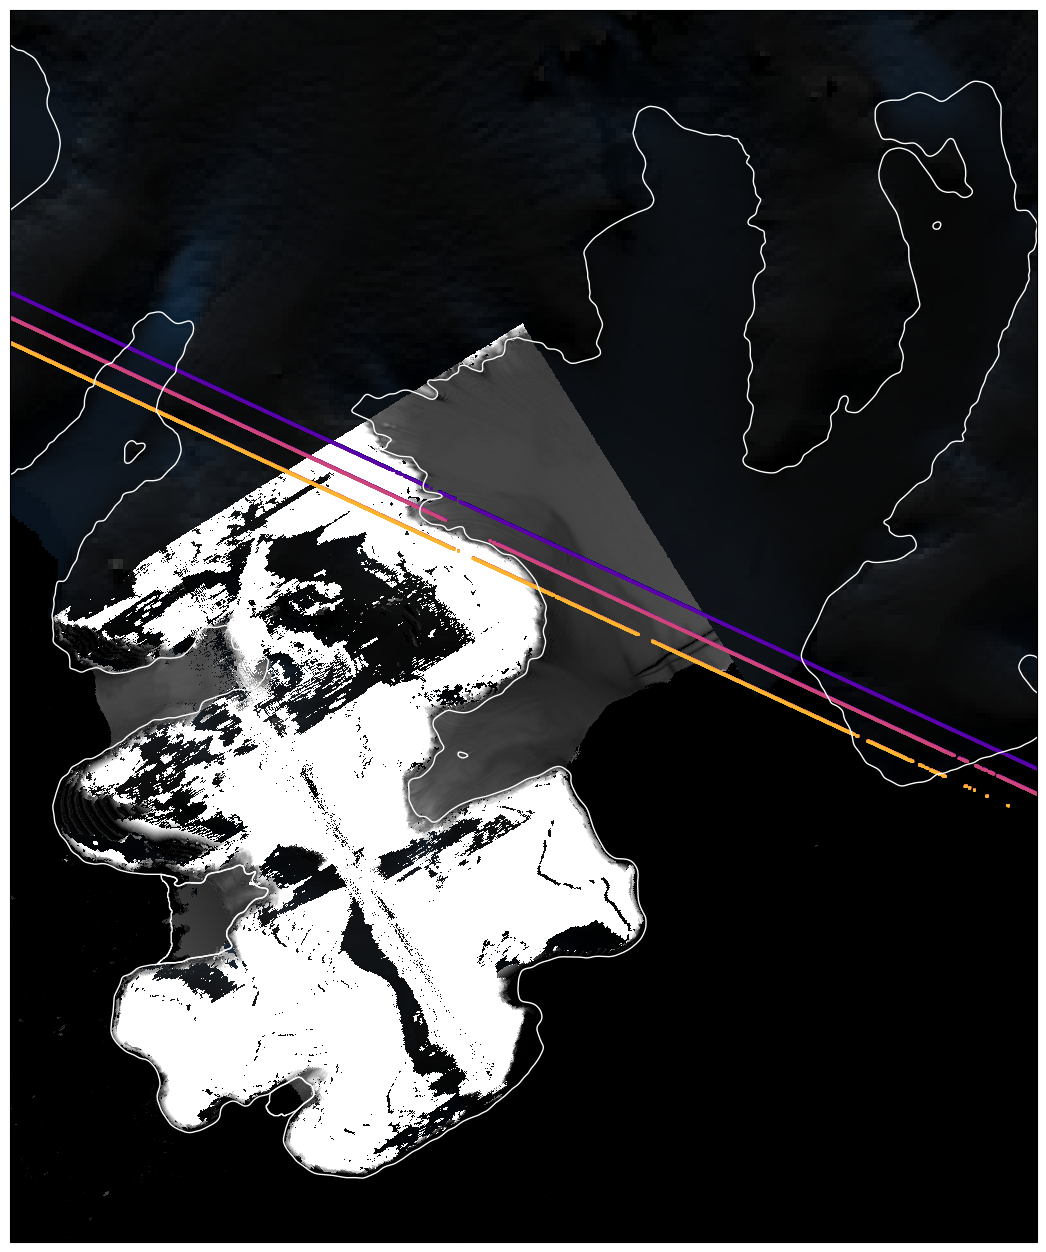

In [28]:
# Find best ATL06 tracks to use
# Trial and error shows ATL06_20241213201922_13522510_006_01.h5 crosses the crevasse

vmin = 0
vmax = 100
is2_start = 114
is2_end = 120
ps71_projection = ccrs.Stereographic(
    central_latitude=-90, central_longitude=0, true_scale_latitude=-71
)
fig, ax = plt.subplots(subplot_kw={"projection": ps71_projection}, figsize=(16, 16))

ax.imshow(moa_dat, extent=ext, cmap="gray", vmin=15000, vmax=27000)
cb = ax.imshow(
    vel_mag_sliced,
    cmap=oslo,
    extent=[
        vel_mag_sliced["x"].min(),
        vel_mag_sliced["x"].max(),
        vel_mag_sliced["y"].min(),
        vel_mag_sliced["y"].max(),
    ],
    origin="upper",
    alpha=0.6,
    vmin=0,
    vmax=1600,
)


wse = ds_swot['wse']#.isel(num_lines=0)
utm = ccrs.UTM(zone=ds.utm_zone_num, southern_hemisphere=True)
x = wse["x"].values
y = wse["y"].values

X, Y = np.meshgrid(x, y)
mesh = ax.pcolormesh(
    X,
    Y,
    wse.values,
    transform=utm,
    cmap="gray",
    shading="auto",
    vmin=vmin,
    vmax=vmax,
)

sf = shapefile.Reader(gl_path)
for i, shape in enumerate(sf.shapes(bbox=bbox)):
    if i > 5:
        points = shape.points
        # Only get points within bounding box
        line = LineString(points)
        plot_line(line, ax=ax, add_points=False, color="white", linewidth=1, zorder=2)

cmap = plt.get_cmap("plasma")

for i, data in enumerate(arr06[is2_start:is2_end]):
    print(data["name"])
    print(data['beam'])
    color = cmap(i / (is2_end - is2_start))
    ax.scatter(data["x"], data["y"], color=color, s=1, transform=ps71_projection)



ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])

In [29]:
# Find granule matching ATL06_20241213201922_13522510_006_01.h5
gran = 'ATL06_20250515130244_09102710_007_01.h5'
beam = 'gt2r'
is2_tracks_to_use = []
for i, data in enumerate(arr06):
    if gran in data['name'] and beam in data['beam']:
        is2_tracks_to_use.append(arr06[i])

assert is2_tracks_to_use, 'No tracks found'

In [30]:
# Create regular gird interpolators to speed up advection of ICESat-2
def prep_velocity_interpolators(vel):
    vx_interp = RegularGridInterpolator(
        (vel.y.values[::-1], vel.x.values),
        vel["VX"].values[::-1, :],
        bounds_error=False,
        fill_value=np.nan,
    )
    vy_interp = RegularGridInterpolator(
        (vel.y.values[::-1], vel.x.values),
        vel["VY"].values[::-1, :],
        bounds_error=False,
        fill_value=np.nan,
    )
    return vx_interp, vy_interp


# Advect ICESat-2 to location at time of SWOT data collection
for track in is2_tracks_to_use:
    start_x = track["x"].copy()
    start_y = track["y"].copy()
    start_time = track["time"].copy()
    # Mask to bbox
    mask = (
        (start_x > bbox[0])
        & (start_x < bbox[2])
        & (start_y > bbox[1])
        & (start_y < bbox[3])
    )
    start_x[~mask] = np.nan
    start_time = [pyasl.decimalYearGregorianDate(t) for t in start_time]
    target_time = st_swot - datetime.timedelta(days=0)
    step_size = 1 / 366  # 1 day
    steps = [(target_time - t) for t in start_time]
    steps = [
        int(step.total_seconds() / (366 * 24 * 60 * 60) / step_size) for step in steps
    ]  # 366 as 2024 leap year

    step_size = np.sign(steps[0]) * step_size
    steps = np.abs(steps)

    # Prep velocity interpolator
    vx_interp, vy_interp = prep_velocity_interpolators(cropped_vel)

    # Assume points want the same number of steps to vectorize
    x = start_x.copy()
    y = start_y.copy()
    for i in range(steps[0]):
        vx = vx_interp((y, x))
        vy = vy_interp((y, x))
        x = x + vx * step_size
        y = y + vy * step_size
    track["x_advected"] = x
    track["y_advected"] = y

In [31]:
ice_shelf_polygons = []
grounded_polygons = []

sf = shapefile.Reader(gl_path)
fields = sf.fields[1:]  # Skip deletion flag
field_names = [field[0] for field in fields]

records = sf.records()
shapes = sf.shapes()

for record, shape in zip(records, shapes):
    classification = record[field_names.index("Id_text")]
    points = shape.points
    parts = list(shape.parts)
    parts.append(len(points))  # Append the end index of the last part
    for i in range(len(parts) - 1):
        part = points[parts[i] : parts[i + 1]]
        polygon = shapely.Polygon(part)
        if (
            classification == "Isolated island"
            or classification == "Ice rise or connected island"
            or classification == "Grounded ice or land"
        ):
            if polygon.is_valid:
                grounded_polygons.append(polygon)
        elif classification == "Ice shelf":
            if polygon.is_valid:
                ice_shelf_polygons.append(polygon)
        else:
            print(f"Unknown classification: {classification}")

# Filter records and shapes to bbox
filtered_records = []
filtered_shapes = []
for record, shape in zip(records, shapes):
    shape_bbox = shape.bbox
    # Checks if any part of the shape is within the bounding box
    if (
        shape_bbox[0] < bbox[2]
        and shape_bbox[2] > bbox[0]
        and shape_bbox[1] < bbox[3]
        and shape_bbox[3] > bbox[1]
    ):
        filtered_records.append(record)
        filtered_shapes.append(shape)

In [32]:
# Find tide corrections using CATS at times of interest

# Swot and ICESat-2 Times
tide_times = [
    st_swot,
    pyasl.decimalYearGregorianDate(is2_tracks_to_use[0]["time"][0]),
]
sats = ["SWOT", "IS2"]
data = is2_tracks_to_use[0]
data["lon_advected"], data["lat_advected"] = xy2ll(
    data["x_advected"], data["y_advected"]
)

for tide_time, satellite in zip(tide_times, sats):
    tides = Tide(tide_mod, tide_dir)
    tide_results = tides.tidal_elevation(
        data["lon_advected"],
        data["lat_advected"],
        [tide_time],
    ).data.T

    data[f"tide_{satellite}"] = tide_results

data["tide_IS2"] = data["tide_IS2"].astype("float32").squeeze()
data["tide_SWOT"] = data["tide_SWOT"].astype("float32").squeeze()

In [33]:
# Make corrected height for fair comp to is2
data["h_li_corrected"] = (
    data["h_li"]
    - data["geoid_h"]
    + data["geoid_free2mean"]
    - data["tide_earth"]
    #+ data["tide_earth_free2mean"]
    - data["tide_pole"]
    - data["tide_load"]
)

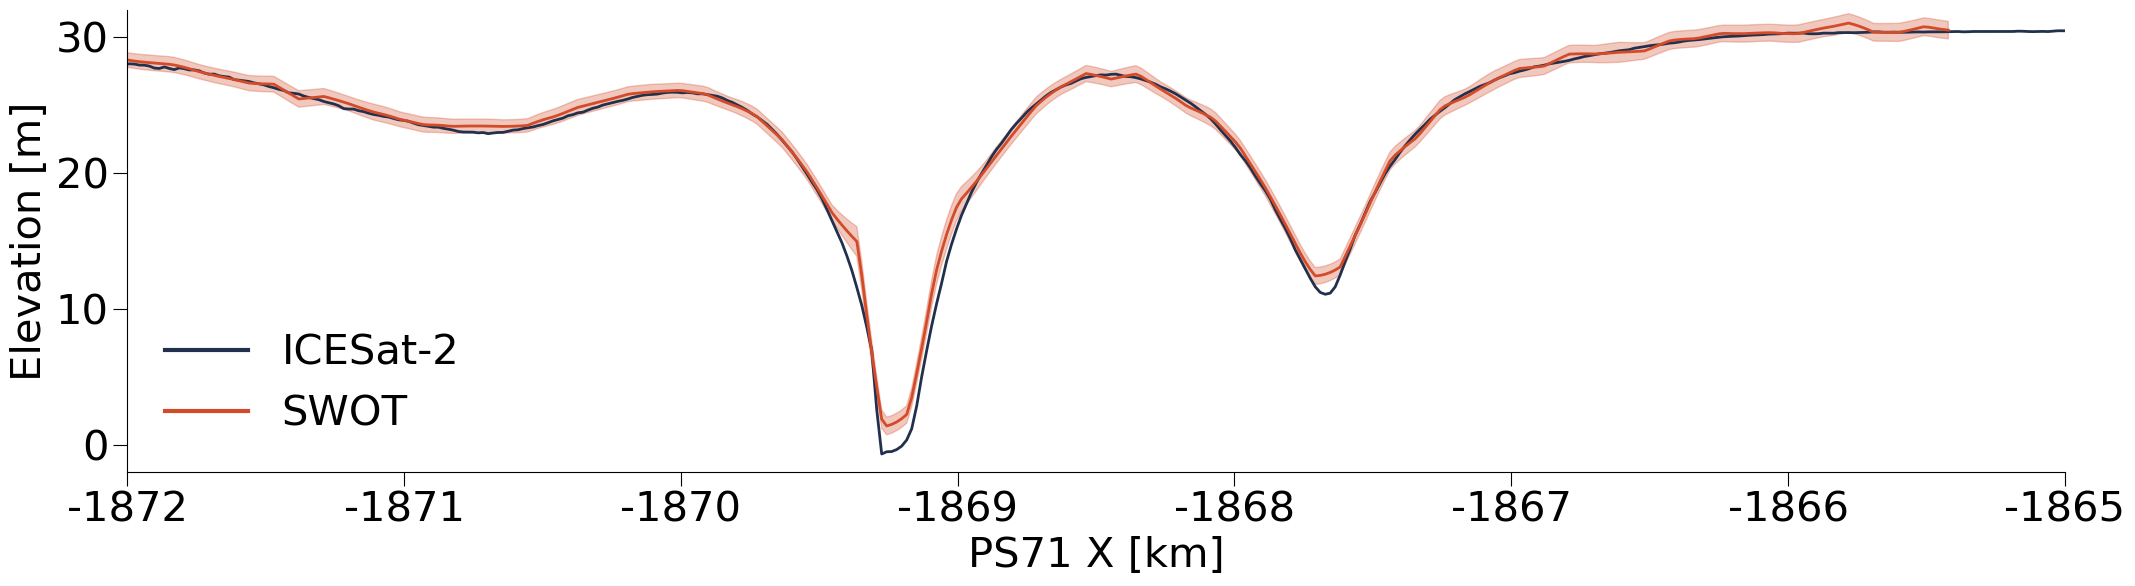

In [34]:
# Interpolate SWOT swath along icesat-2 track
to_plot = "wse"

fig, ax = plt.subplots(figsize=(25, 6))

overall_wse = np.zeros_like(data["x_advected"])
overall_wse[:] = np.nan
overall_wse_sigma = np.zeros_like(data["x_advected"])
overall_wse_sigma[:] = np.nan

wse = ds_swot[to_plot]#.isel(num_lines=0)
wse_sigma = ds_swot["wse_uncert"]#.isel(num_lines=0)
utm = ccrs.UTM(zone=ds.utm_zone_num, southern_hemisphere=True)
ps71_projection = ccrs.Stereographic(
    central_latitude=-90, central_longitude=0, true_scale_latitude=-71
)
# Convert icesat2 to utm
x_utm = wse["x"].values
y_utm = wse["y"].values
advected_x_utm, advected_y_utm = ps712utm(
    data["x_advected"], data["y_advected"], utm.to_epsg()
)

advected_x_utm = xr.DataArray(advected_x_utm, dims=["points"])
advected_y_utm = xr.DataArray(advected_y_utm, dims=["points"])

x_utm = wse["x"].values
y_utm = wse["y"].values

interpolated_wse = wse.interp(
    x=advected_x_utm,
    y=advected_y_utm,
    method="linear",
    kwargs={"fill_value": np.nan},
).compute()
interpolated_wse_sigma = wse_sigma.interp(
    x=advected_x_utm,
    y=advected_y_utm,
    method="linear",
    kwargs={"fill_value": np.nan},
).compute()

# Put all non-nan values into overall_wse
mask = np.isnan(overall_wse) & ~np.isnan(interpolated_wse)

# Only update at those places
overall_wse[mask] = interpolated_wse[mask]
overall_wse_sigma[mask] = interpolated_wse_sigma[mask]

lower = overall_wse - 2 * overall_wse_sigma
upper = overall_wse + 2 * overall_wse_sigma

ax.plot(
    data["x_advected"],
    data["h_li_corrected"] - data["tide_IS2"] / 100,
    color="#21314D",
    linewidth=2,
    label="ICESat-2",
)
ax.plot(
    data["x_advected"],
    overall_wse - data["tide_SWOT"] / 100,
    color="#D34B29",
    linewidth=2,
    label="SWOT",
)
ax.fill_between(
    data["x_advected"],
    lower - data["tide_SWOT"] / 100,
    upper - data["tide_SWOT"] / 100,
    color="#D34B29",
    alpha=0.3,
)

ax.set_xlabel("PS71 X [km]", fontsize=30)
ax.set_ylabel("Elevation [m]", fontsize=30)
KM_SCALE = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
ax.xaxis.set_major_formatter(ticks_x)
ax.tick_params(axis="both", which="major", labelsize=30, size=10)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim(np.nanmin(data["x_advected"]), np.nanmax(data["x_advected"]))
# Find firs and last non nan index of interpolated wse
first_non_nan = np.where(~np.isnan(overall_wse))[0][0]
last_non_nan = np.where(~np.isnan(overall_wse))[0][-1]

# Mask to values shown in chart
min_mask = -1872000
max_mask = -1865000
x_mask = (data["x_advected"] > min_mask) & (
    data["x_advected"] < max_mask
)

ax.set_xlim(min_mask, max_mask) 
ax.set_ylim(-2, 32)

ax.legend(fontsize=30, loc="lower left")
# Remove legend border
leg = ax.get_legend()
for line in leg.get_lines():
    line.set_linewidth(3)
# Set legend border color and width
leg.get_frame().set_edgecolor("white")
leg.get_frame().set_linewidth(1)

# Flip x axis
# ax.set_xlim(ax.get_xlim()[::-1])

PLOTTING RASTERS
PLOTTING ICESAT-2
COLORBARS
SCALEBAR AND INSET


/tmp/ipykernel_53604/4090443241.py:260: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


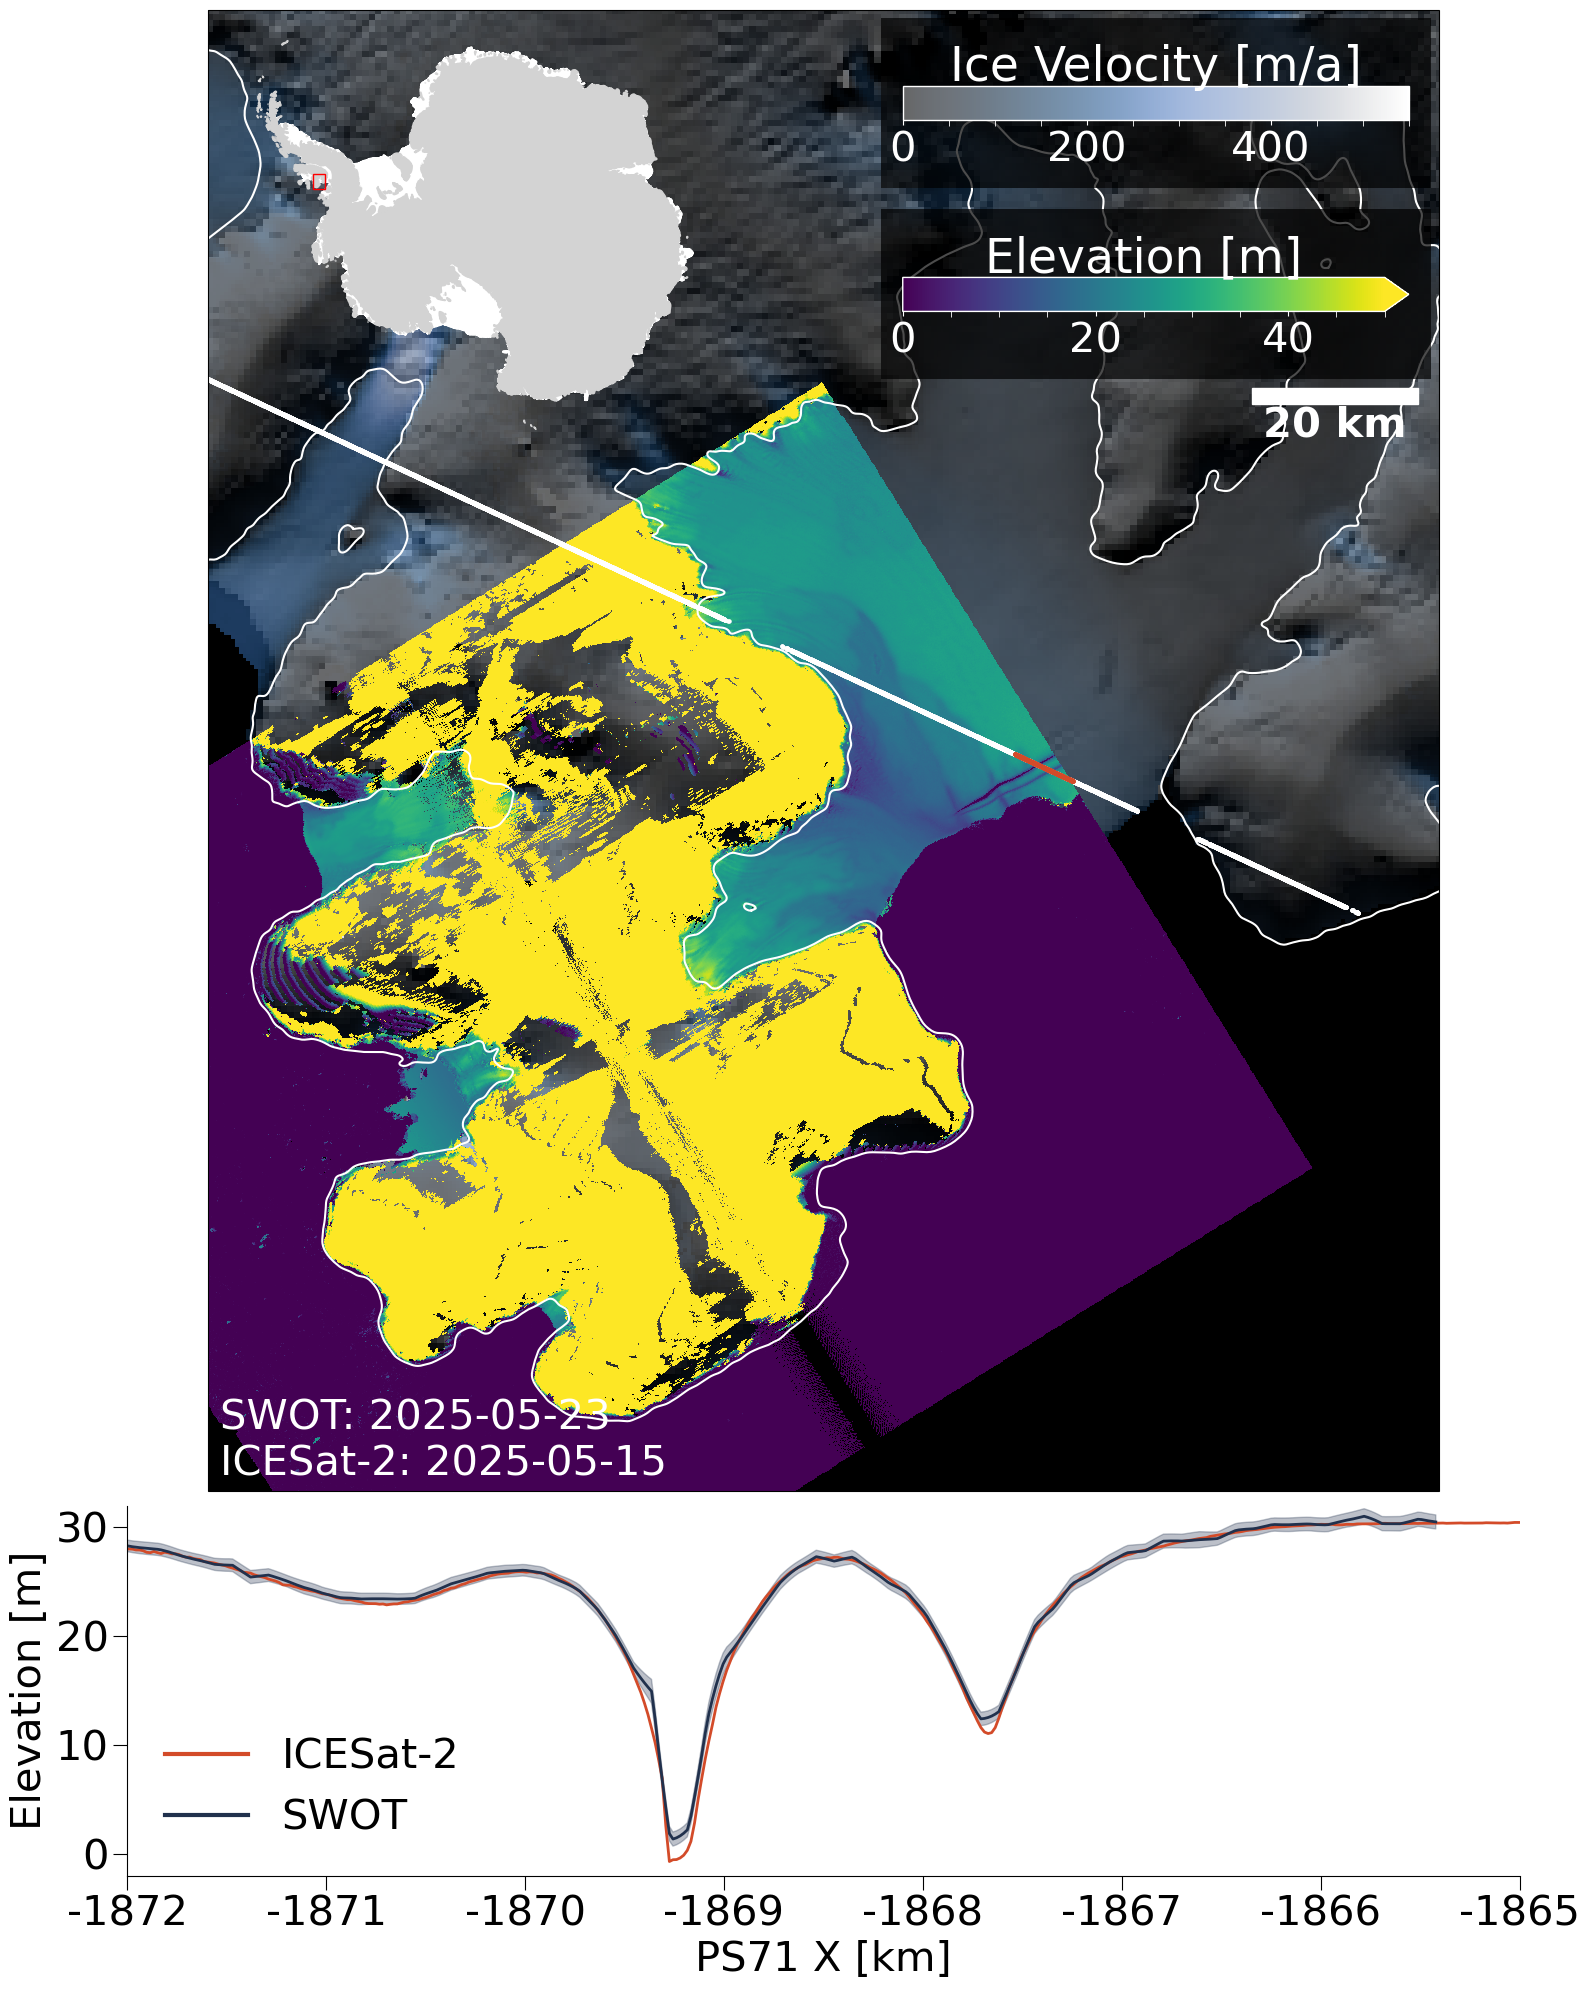

In [38]:
# Plot combined comparison!


to_plot = "wse"
label = "Elevation [m]"
vmin = 0
vmax = 50

ps71_projection = ccrs.Stereographic(
    central_latitude=-90, central_longitude=0, true_scale_latitude=-71
)
fig = plt.figure(figsize=(16, 20))

gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = fig.add_subplot(gs[0], projection=ps71_projection)

ax.imshow(moa_dat, extent=ext, cmap="gray", vmin=15000, vmax=17000)
cb = ax.imshow(
    vel_mag_sliced,
    cmap=oslo,
    extent=[
        vel_mag_sliced["x"].min(),
        vel_mag_sliced["x"].max(),
        vel_mag_sliced["y"].min(),
        vel_mag_sliced["y"].max(),
    ],
    origin="upper",
    alpha=0.6,
    vmin=0,
    vmax=550,
)
plot_shapefile(records, shapes, ax, ["white", "none"], ps71_projection, fill=False)
print("PLOTTING RASTERS")

wse = ds_swot[to_plot]#.isel(num_lines=0)
if to_plot == "wse":
    xover_corr = ds_swot["height_cor_xover"]#.isel(num_lines=0)
    wse = wse + xover_corr
utm = ccrs.UTM(zone=ds.utm_zone_num, southern_hemisphere=True)
x = wse["x"].values
y = wse["y"].values

X, Y = np.meshgrid(x, y)
mesh = ax.pcolormesh(
    X,
    Y,
    wse.values,
    transform=utm,
    cmap="viridis",
    shading="auto",
    vmin=vmin,
    vmax=vmax,
)

print("PLOTTING ICESAT-2")
ax.scatter(
    data["x_advected"],
    data["y_advected"],
    color="white",
    s=5,
    transform=ps71_projection,
)

ax.set_xlim(bbox[0] + 1000, bbox[2] - 1000)
ax.set_ylim(bbox[1] + 1000, bbox[3] - 1000)

print("COLORBARS")
k_cbar_anchor = (0.999, 0.87)
cbbox = inset_axes(
    ax,
    width=5.5,
    height=1.7,
    bbox_to_anchor=k_cbar_anchor,
    bbox_transform=ax.transAxes,
    loc="upper right",
)
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.tick_params(
    axis="both",
    left=False,
    top=False,
    right=False,
    bottom=False,
    labelleft=False,
    labeltop=False,
    labelright=False,
    labelbottom=False,
)
cbbox.set_facecolor([0, 0, 0, 0.7])

cbaxes = inset_axes(cbbox, "92%", "20%", loc="center")
cbar = fig.colorbar(
    mesh, cax=cbaxes, orientation="horizontal", extend="max"
)  # make colorbar
cbar.outline.set_edgecolor("white")
cbar.outline.set_linewidth(1)
cbar.ax.tick_params(labelsize=30, color="white", labelcolor="white")
cbar.set_label(label, fontsize=34, color="white")
cbar.ax.xaxis.set_label_position("top")

cbar.ax.minorticks_on()

cbar.ax.tick_params(which="minor", length=4, color="white")


v_cbar_anchor = (0.999, 0.999)
cbbox = inset_axes(
    ax,
    width=5.5,
    height=1.7,
    bbox_to_anchor=v_cbar_anchor,
    bbox_transform=ax.transAxes,
    loc="upper right",
)
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.tick_params(
    axis="both",
    left=False,
    top=False,
    right=False,
    bottom=False,
    labelleft=False,
    labeltop=False,
    labelright=False,
    labelbottom=False,
)
cbbox.set_facecolor([0, 0, 0, 0.7])

cbaxes = inset_axes(cbbox, "92%", "20%", loc="center")
cbar = fig.colorbar(cb, cax=cbaxes, orientation="horizontal")  # make colorbar
cbar.outline.set_edgecolor("white")
cbar.outline.set_linewidth(1)
cbar.ax.tick_params(labelsize=30, color="white", labelcolor="white")
cbar.set_label("Ice Velocity [m/a]", fontsize=34, color="white")
cbar.ax.xaxis.set_label_position("top")

cbar.ax.minorticks_on()

cbar.ax.tick_params(which="minor", length=4, color="white")

print("SCALEBAR AND INSET")
scalebar = AnchoredSizeBar(
    ax.transData,
    20000,
    "20 km",
    "lower right",
    pad=0.1,
    sep=1,
    color="white",
    frameon=False,
    size_vertical=2000,
    fontproperties=mpl.font_manager.FontProperties(size=30, weight="bold"),
    label_top=False,
)

# Add inset map using moa grounding lines
inset = fig.add_axes(
    [0.15, 0.73, 0.3, 0.3], projection=ps71_projection
)  # [left, bottom, width, height]
inset.patch.set_facecolor("none")
for spine in inset.spines.values():
    spine.set_visible(False)
inset.set_xticks([])
inset.set_yticks([])

plot_shapefile(
    records, shapes, inset, ["lightgray", "white"], ps71_projection, fill=True
)
rect = plt.Rectangle(
    (
        bbox[0],
        bbox[1],
    ),
    bbox[2] - bbox[0],
    bbox[3] - bbox[1],
    zorder=3,
    linewidth=1,
    edgecolor="red",
    facecolor="none",
)
inset.add_patch(rect)


ax.add_artist(scalebar)
scalebar.set_bbox_to_anchor((0.99, 0.7), transform=ax.transAxes)


plt.draw()

x_plotting = data["x_advected"][x_mask]
y_plotting = data["y_advected"][x_mask]
ax.scatter(x_plotting, y_plotting, color="#D34B29", s=5, transform=ps71_projection)

ax2 = fig.add_subplot(gs[1])
ax2.plot(
    data["x_advected"],
    data["h_li_corrected"] - data["tide_IS2"] / 100,
    color="#D34B29",
    linewidth=2,
    label="ICESat-2",
)
ax2.plot(
    data["x_advected"],
    overall_wse - data["tide_SWOT"] / 100,
    color="#21314D",
    linewidth=2,
    label="SWOT",
)
ax2.fill_between(
    data["x_advected"],
    lower - data["tide_SWOT"] / 100,
    upper - data["tide_SWOT"] / 100,
    color="#21314D",
    alpha=0.3,
)


ax2.set_xlabel("PS71 X [km]", fontsize=30)
ax2.set_ylabel("Elevation [m]", fontsize=30)
KM_SCALE = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
ax2.xaxis.set_major_formatter(ticks_x)
ax2.tick_params(axis="both", which="major", labelsize=30, size=10)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.set_xlim(np.nanmin(data["x_advected"]), np.nanmax(data["x_advected"]))
# Find first and last non nan index of interpolated wse
first_non_nan = np.where(~np.isnan(overall_wse))[0][0]
last_non_nan = np.where(~np.isnan(overall_wse))[0][-1]
ax2.set_xlim(min_mask, max_mask)  
ax2.set_ylim(-2, 32)

handles = [
    Line2D([0], [0], color="#D34B29", linewidth=2, label="ICESat-2"),
    Line2D([0], [0], color="#21314D", linewidth=2, label="SWOT"),
    Patch(facecolor="#21314D", alpha=0.3, label="SWOT Uncertainty"),
]

ax2.legend(
    fontsize=30,
    loc="lower left",
    handles=handles[:1] + [handles[1]],
)
# Remove legend border
leg = ax2.get_legend()
for line in leg.get_lines():
    line.set_linewidth(3)
# Set legend border color and width
leg.get_frame().set_edgecolor("white")
leg.get_frame().set_linewidth(1)

ax.text(
    0.01,
    0.01,
    "SWOT: 2025-05-23\nICESat-2: 2025-05-15",
    transform=ax.transAxes,
    fontsize=30,
    color="white",
    justify='left'
)
fig.tight_layout()